# Select events and compute maps for run 7431

## Scope 

- This NB selects events and computes XY maps for run 7431.

- Run 7431. August 2019. HE run. 


### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/ICAROS/

## Imports

In [1]:
import time
import os
print("Last updated on ", time.asctime())

Last updated on  Wed Aug 21 16:17:40 2019


In [2]:
bootstrap   = 7439
run_number  = 7431
file_range  = 0, 9067

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v1.1.0_20190801_krbg'

boot_emap_filename   = os.path.expandvars(f'$IC_DATA/maps/kr_emap_xy_100_100_r_{bootstrap}.h5')
emap_filename        = os.path.expandvars(f'$IC_DATA/maps/kr_emap_xy_50_50_r_{run_number}.h5')
qmap_filename        = os.path.expandvars(f'$IC_DATA/maps/kr_qmap_xy_50_50_r_{run_number}.h5')
write_filtered_dst   = True
print(f'boot emap ={boot_emap_filename}')
print(f'emap ={emap_filename}')
print(f'qmap ={qmap_filename}')

boot emap =/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_7439.h5
emap =/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_50_50_r_7431.h5
qmap =/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_qmap_xy_50_50_r_7431.h5


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import sys
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import warnings
import seaborn as sns
sns.set()

In [5]:
from numpy import pi, sqrt

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [7]:
import krcal.dev.corrections                  as corrections 
import krcal.utils.hst_extend_functions       as hst
from krcal.core import fit_functions_ic       as fitf
import invisible_cities.reco.corrections      as corrf

In [8]:
from krcal.core.core_functions                import time_delta_from_time
from krcal.core.core_functions                import phirad_to_deg
from krcal.core.core_functions                import NN
from krcal.core.core_functions                import timeit
from krcal.core.core_functions                import data_frames_are_identical

from krcal.core.io_functions                  import filenames_from_paths
from krcal.core.io_functions                  import filenames_from_list
from krcal.core.io_functions                  import kdst_write
from krcal.core.io_functions                  import write_maps
from krcal.core.io_functions                  import read_maps
from krcal.core.io_functions                  import write_maps_ts
from krcal.core.io_functions                  import read_maps_ts

from krcal.core.ranges_and_bins_functions     import kr_ranges_and_bins

from krcal.core.histo_functions               import h1, h1d, h2, h2d, profile1d, plot_histo
from krcal.core.kr_types                      import PlotLabels, FitType

from krcal.core.s1s2_functions                import s1d_from_dst
from krcal.core.s1s2_functions                import s2d_from_dst
from krcal.core.s1s2_functions                import plot_s1histos
from krcal.core.s1s2_functions                import plot_s2histos
from krcal.core.s1s2_functions                import energy_time_profile
from krcal.core.s1s2_functions                import energy_X_profile

from krcal.core.plt_functions                 import plot_xy_density
from krcal.core.plt_functions                 import plot_s1_vs_z
from krcal.core.plt_functions                 import plot_s2_vs_z
from krcal.core.plt_functions                 import plot_s2_vs_s1
from krcal.core.plt_functions                 import plot_q_vs_s2
from krcal.core.plt_functions                 import plot_energy_distributions
from krcal.core.plt_functions                 import plot_energy_vs_t

from krcal.core.selection_functions           import event_map_df
from krcal.core.selection_functions           import select_rphi_sectors_df
from krcal.core.selection_functions           import select_xy_sectors_df
from krcal.core.selection_functions           import get_time_series_df
from krcal.core.fitmap_functions              import time_fcs_df
from krcal.core.fitmap_functions              import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions              import fit_map_xy_df

from krcal.core.map_functions                 import tsmap_from_fmap
from krcal.core.map_functions                 import amap_from_tsmap
from krcal.core.map_functions                 import relative_errors
from krcal.core.map_functions                 import amap_average
from krcal.core.map_functions                 import amap_max
from krcal.core.map_functions                 import amap_min
from krcal.core.map_functions                 import amap_replace_nan_by_mean
from krcal.core.map_functions                 import amap_replace_nan_by_zero
from krcal.core.map_functions                 import regularize_maps
from krcal.core.map_functions                 import get_maps_from_tsmap
from krcal.core.map_functions                 import map_average
from krcal.core.map_functions                 import add_mapinfo

from krcal.core.xy_maps_functions             import draw_xy_maps
from krcal.core.xy_maps_functions             import draw_xy_map
from krcal.core.xy_maps_functions             import draw_xy_maps_ts

from krcal.core.rphi_maps_functions           import draw_rphi_maps
from krcal.core.rphi_maps_functions           import draw_rphi_map
from krcal.core.rphi_maps_functions           import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions           import draw_wedges
from krcal.core.rphi_maps_functions           import define_rphi_sectors
from krcal.core.rphi_maps_functions           import rphi_sector_map_def

from krcal.core.correction_functions          import e0_rphi_correction
from krcal.core.correction_functions          import e0_xy_correction
from krcal.core.correction_functions          import lt_xy_correction
from krcal.core.correction_functions          import e0_xy_correction_ts
from krcal.core.correction_functions          import lt_xy_correction_ts
from krcal.core.correction_functions          import lt_rphi_correction
from krcal.core.correction_functions          import lt_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts

from krcal.core.fit_lt_histograms             import plot_time_fcs
from krcal.core.fit_energy_functions          import fit_energy
from krcal.core.fit_energy_functions          import plot_fit_energy
from krcal.core.fit_energy_functions          import print_fit_energy
from krcal.core.fit_energy_functions          import resolution_r_z
from krcal.core.fit_energy_functions          import plot_resolution_r_z

from krcal.core.selection_functions           import selection_info
from krcal.core.selection_functions           import selection_in_band
from krcal.core.selection_functions           import plot_selection_in_band

### Logger

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [9]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')
log = logging.getLogger()

2019-08-21 16:17:42,768 | INFO : Hello world!


### Input/output 

In [10]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/7431/kdst_0000_7431_trigger1_v1.1.0_20190801_krbg.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/7431/kdst_9066_7431_trigger1_v1.1.0_20190801_krbg.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7431_trigger1_0000_9066.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_7431_trigger1_0000_9066.h5


In [11]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [12]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 3527469 
Total number of events: 1760702


In [13]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [14]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 3527469


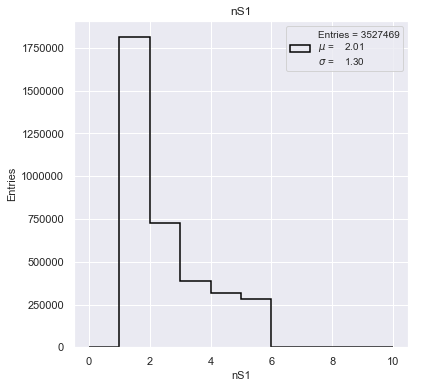

In [15]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [16]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.5147591658495085


In [17]:
dst1s1 = dst_full[in_range(dst_full.nS1, 1,2)]

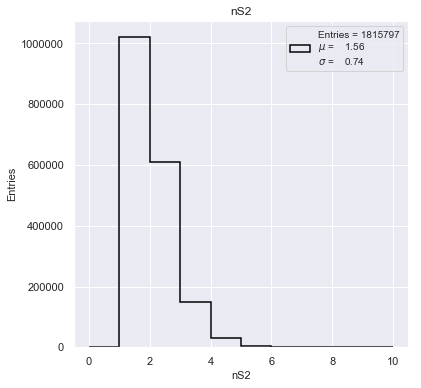

In [18]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

In [19]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.5630243909423795


In [20]:
dst    = dst1s1[in_range(dst1s1.nS2, 1, 2)]

In [21]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1022338: selection eff = 0.2898219658344269 


In [22]:
s1d = s1d_from_dst(dst)

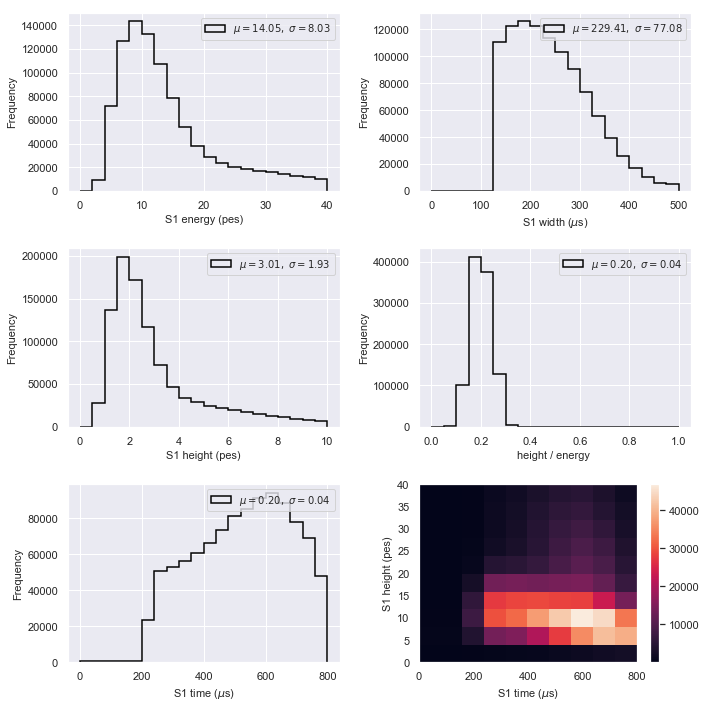

In [23]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

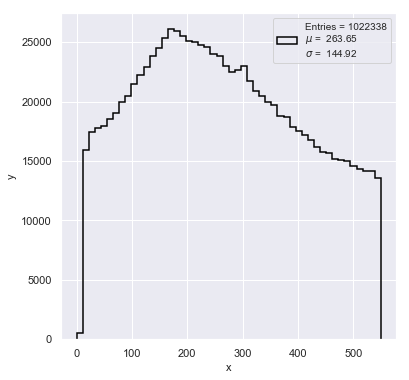

In [24]:
(_) = h1d(dst.Z, bins = 50, range =(0,550))

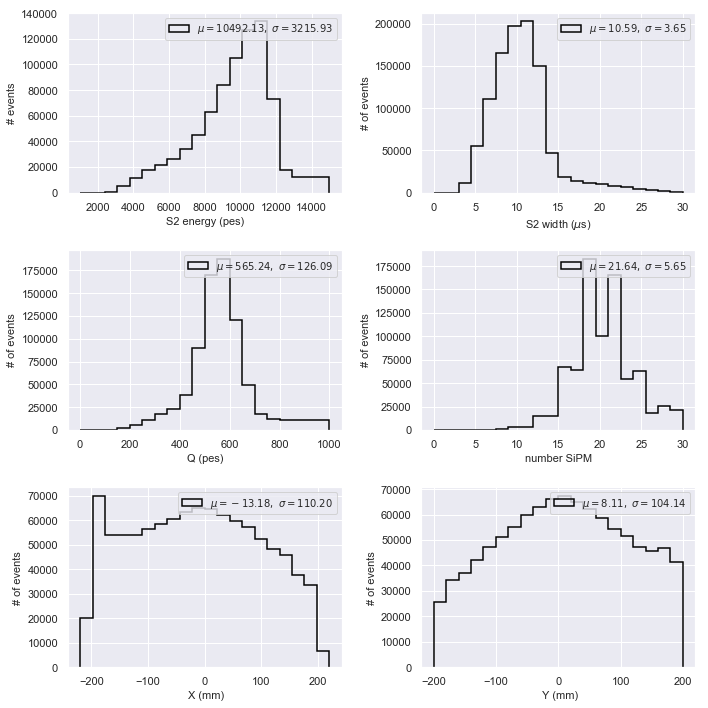

In [25]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Ranges and binning

In [26]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 20000)
s2q_range = (100, 1000)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range   = s2e_range
lt_range  = (1000, 11000)
c2_range  = (0,5)
time_bins = 1

## 50 x 50 bins for map

In [27]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [28]:
krRanges

KrRanges(S2e=(2000, 20000), S1e=(3, 25), S2q=(100, 1000), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(1565349053.834, 1565436044.504))

In [29]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=50, Y=50, Xsi=50, Ysi=50, Z=15, T=24)

### Sort DST in time and add DT column (DT is a vector of time differences)

In [30]:
dstx     = dst[in_range(dst.X, -RMAX, RMAX)]
dst      = dstx[in_range(dstx.Y, -RMAX, RMAX)]
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst.assign(DT=DT)
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

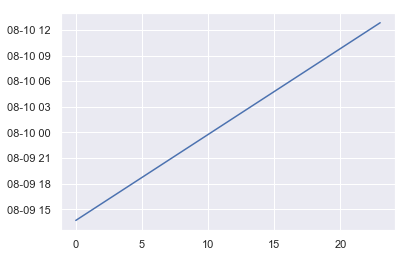

In [31]:
plt.plot(krTimes.timeStamps)

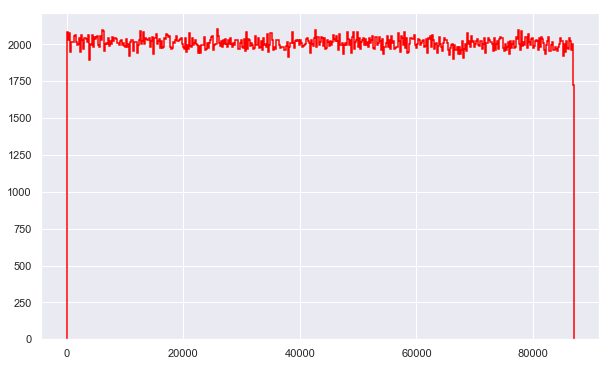

In [32]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.DT.values, bins=500, range = (dst.DT.values[0], dst.DT.values[-1]), color='red', stats=False, lbl='pre-sel')

### Event distribution

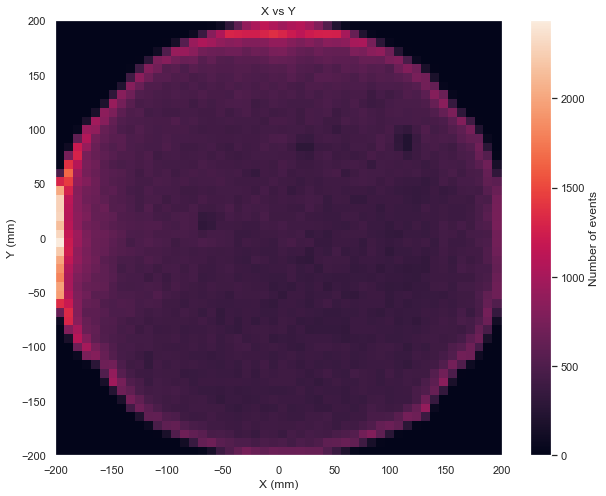

In [33]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, (-200,200), (-200,200), 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## load bootstrap map

In [34]:
emaps = read_maps(filename=boot_emap_filename)
norm = amap_max(emaps)
norm

ASectorMap(chi2=3.2363782362084965, e0=12646.619870064445, lt=11627.746602188212, e0u=0.7482773902330715, ltu=14.88768408290421, mapinfo=None)

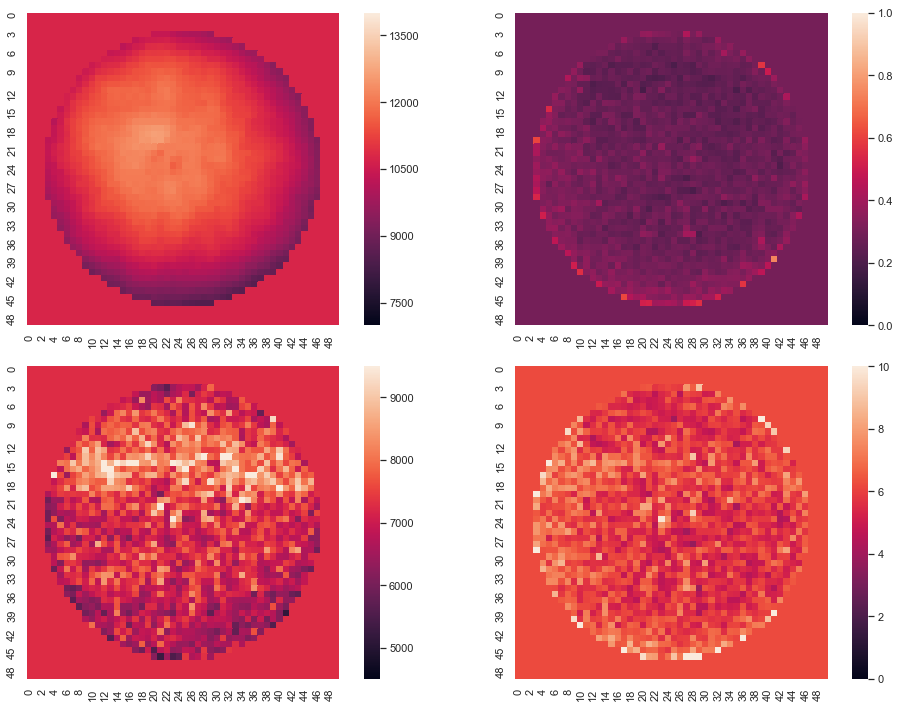

In [35]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (4500, 9500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

## Compute E0 correction from bootstrap map

In [36]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 10.489027738571167 s


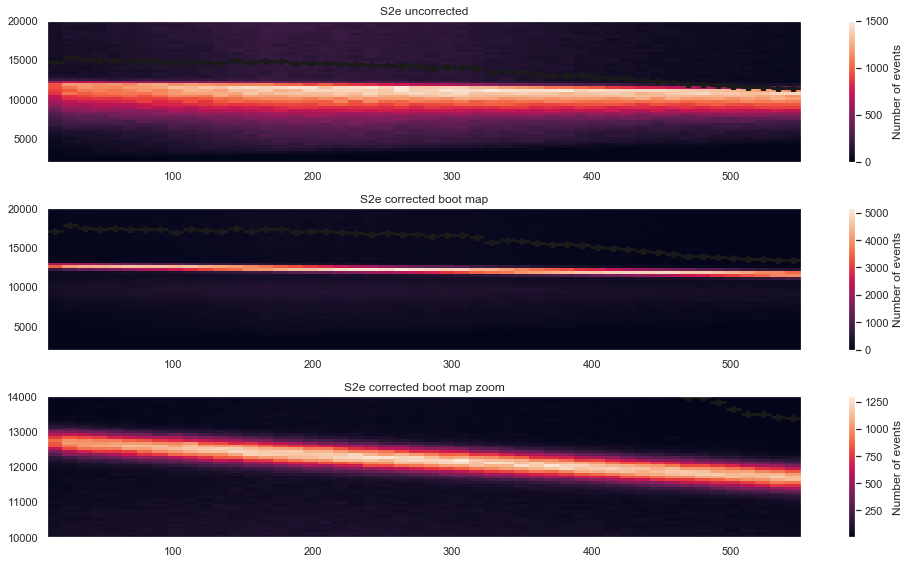

In [37]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
plt.title('S2e uncorrected')
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
plt.title('S2e corrected boot map')
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, (1e+4,14e+3), 
           profile=True)
plt.title('S2e corrected boot map zoom')
plt.tight_layout()

## Band selection

In [38]:
range_krs2 = (10.0e+3,14e+3)
sel_krband, fpl, fph, hp, pp = selection_in_band(dst.Z, E0,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.0)

/Users/jjgomezcadenas/Projects/KrCalib2/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jjgomezcadenas/Projects/KrCalib2/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


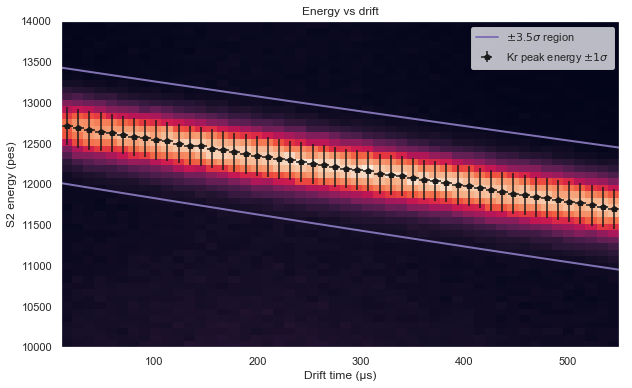

In [39]:

plot_selection_in_band(fpl, fph, hp, pp)

In [40]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 476525 (47.4 %)


'Total number of selected candidates Kr band: 476525 (47.4 %)'

## Define dsts (selected dst) and dstf (fiducial dst)

In [41]:
dst = dst.assign(E0=E0)

In [42]:
dsts = dst[sel_krband]

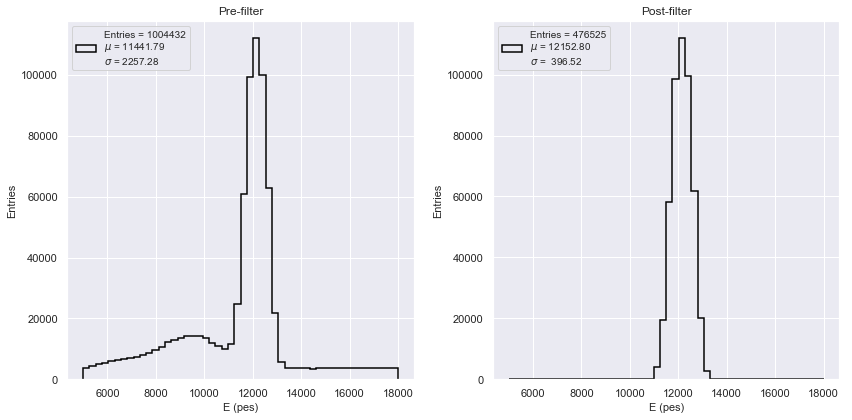

In [43]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.E0,  bins = 50, range =(5000,18000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dsts.E0,  bins = 50, range =(5000,18000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

In [44]:
dstf = dsts[dsts.R <= RFID]

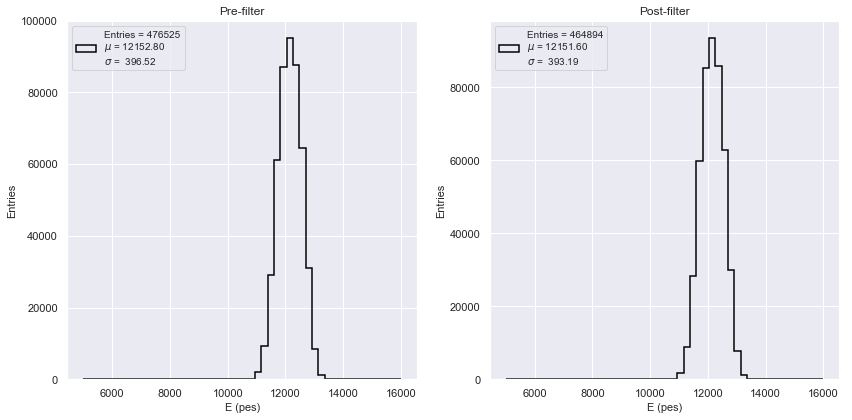

In [45]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dsts.E0,  bins = 50, range =(5000,16000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dstf.E0,  bins = 50, range =(5000,16000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

## S1 & S2 distributions for fiducial dst, showing that remaining data looks krypton

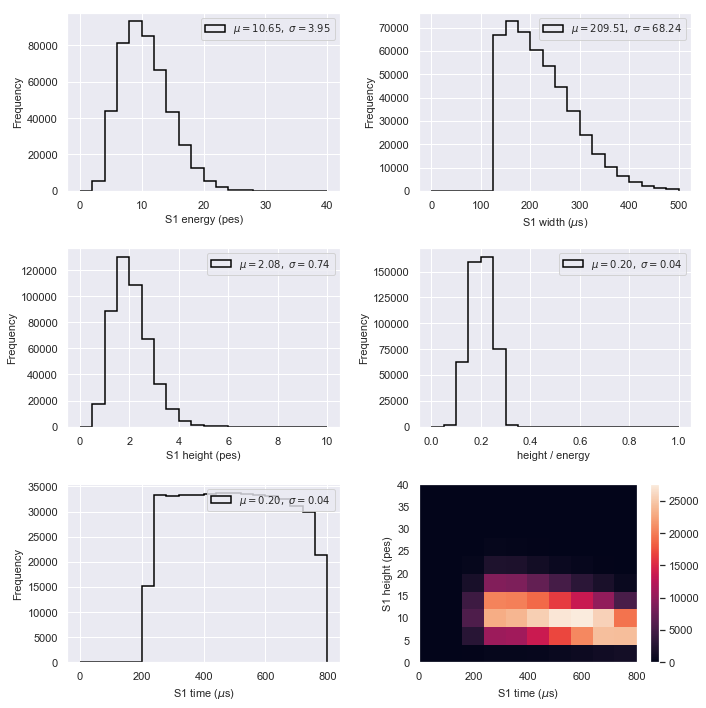

In [46]:
s1d = s1d_from_dst(dstf)
plot_s1histos(dstf,  s1d, bins=20, figsize=(10,10))

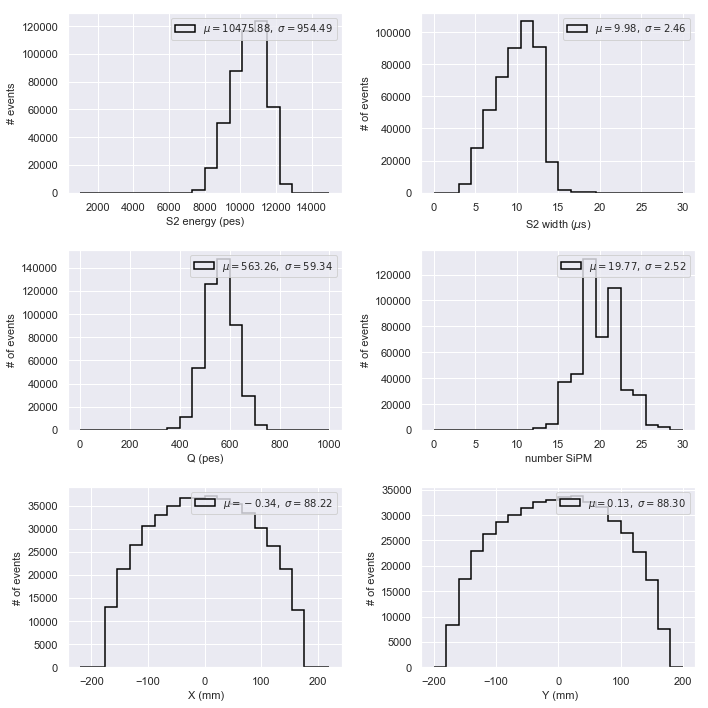

In [47]:
s2d = s2d_from_dst(dstf)
plot_s2histos(dstf, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

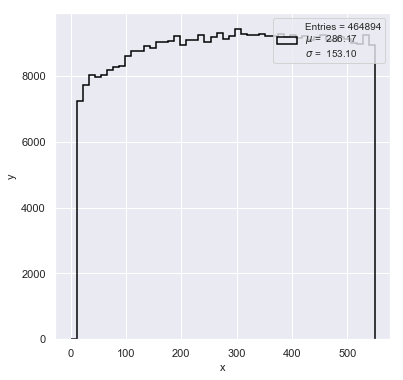

In [48]:
(_) = h1d(dstf.Z, bins = 50, range =(0,550))

## Time series, showing lifetime very high and flat

In [49]:
time_bins = 5
ti = timeit(get_time_series_df)
ts, masks = ti(time_bins, (DT[0],DT[-1]), dstf)

Time spent in get_time_series_df: 0.0033998489379882812 s


In [50]:
ti = timeit(time_fcs_df)
fps = ti(ts, masks, dstf, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         fit     = FitType.profile)

Time spent in time_fcs_df: 0.11159706115722656 s


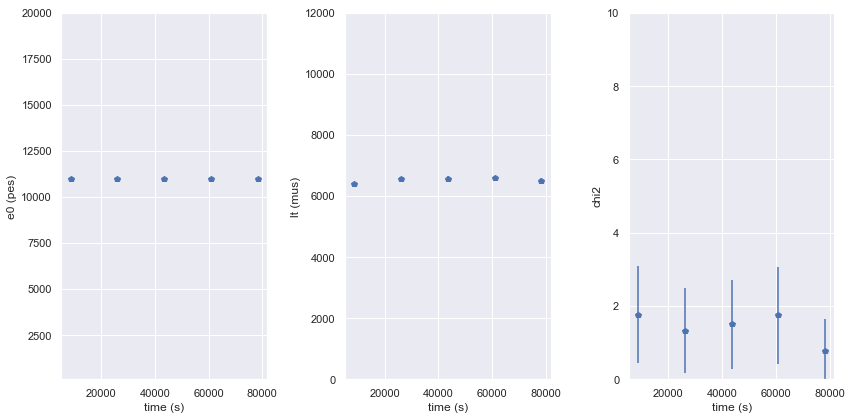

In [51]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (0, 12000),
              figsize     = (12,6))

# This end the selection part:

- dsts is the selected dst (R < 200).
- dstf is the selected fiducial dst (R < 180).

# Single-run maps

## Divide chamber in sectors of XY

In [52]:
log.setLevel(logging.INFO) # turn to DEBUG to follow progress of this part 

In [53]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dsts, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 2.4095730781555176 s


In [54]:
nXY = event_map_df(KXY)

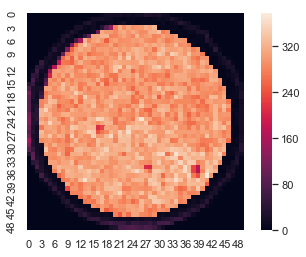

In [55]:
ax = sns.heatmap(nXY, square=True)

## Fits in XY sectors

## Maps

#### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)

In [56]:
log.setLevel(logging.INFO)

In [57]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 5.365319013595581 s


#### The second step is to obtain the maps themselves from the fit-map-XY

In [58]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.0013439655303955078 s


#### Third step: select the corresponding map in the time series (in this case just one, ts=0)

In [59]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [60]:
log.setLevel(logging.INFO)

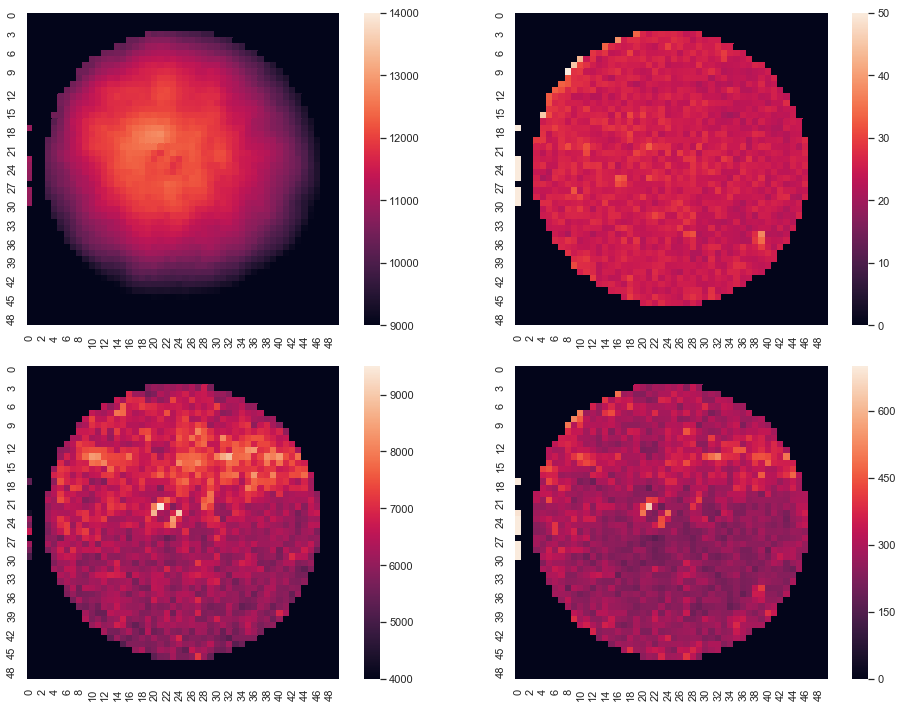

In [61]:
draw_xy_maps(am,
            e0lims  = (9000, 14000),
            ltlims  = (4000, 9500),
            eulims  = (0.0,  50),
            lulims  = (0, 700),
            figsize=(14,10))

In [62]:
amap_average(am) 

ASectorMap(chi2=0.9335722663203392, e0=10830.228167925536, lt=6440.532896991428, e0u=26.847149913188858, ltu=306.11525383314904, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [63]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-08-21 16:21:47,203 | INFO :  set nans to average value of interval = 11000.0
2019-08-21 16:21:47,247 | INFO :  set nans to average value of interval = 6000.0


In [64]:
amap_average(rmap)

ASectorMap(chi2=0.9335722663203392, e0=10830.228167925536, lt=6440.532896991428, e0u=26.847149913188858, ltu=306.11525383314904, mapinfo=None)

In [65]:
asm = relative_errors(rmap)

In [66]:
amv = amap_average(asm)
amv

ASectorMap(chi2=0.9335722663203392, e0=10830.228167925536, lt=6440.532896991428, e0u=0.2494671666218797, ltu=4.773562930608783, mapinfo=None)

#### Draw the maps using default colormap

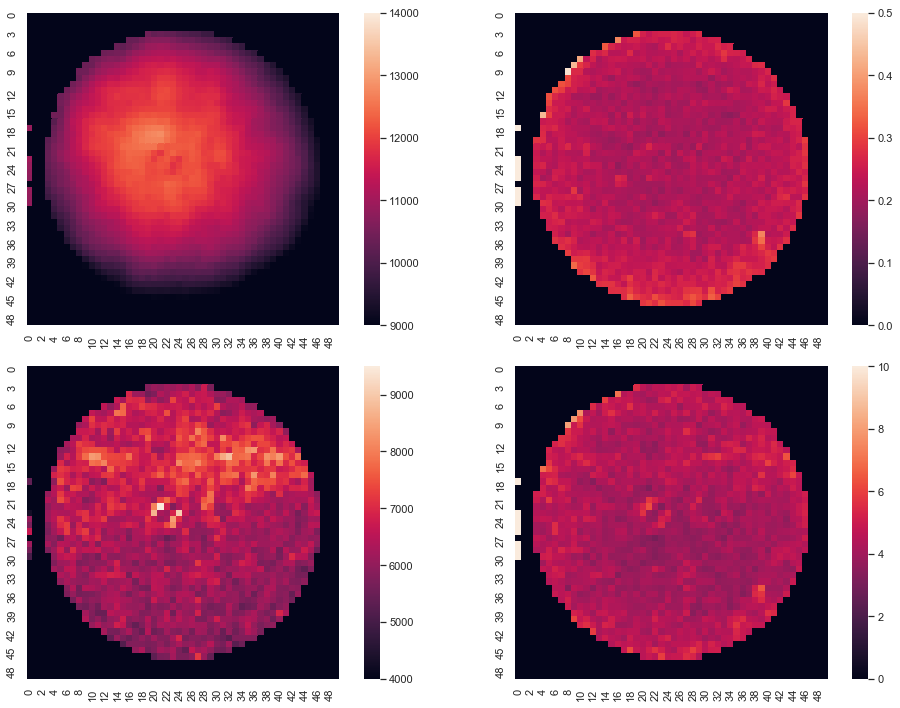

In [67]:
draw_xy_maps(asm,
            e0lims  = (9000, 14000),
            ltlims  = (4000, 9500),
            eulims  = (0.0,  0.5),
            lulims  = (0, 10),
            figsize=(14,10))

In [68]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [69]:
amap_average(asmAv)

ASectorMap(chi2=0.9279997842263518, e0=10915.176651177753, lt=6463.687221247295, e0u=0.24143213026445579, ltu=4.58339425731854, mapinfo=None)

In [70]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=run_number)

In [71]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    7431
dtype: int64

## Write new maps

In [72]:
print(f'writing emaps in {emap_filename}')
write_maps(asm, filename=emap_filename)

writing emaps in /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_50_50_r_7431.h5


## Compute also maps for SiPM plane

In [73]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy2 = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = s2q_range,
              energy         = 'S2q',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 50)

Time spent in fit_map_xy_df: 5.691524982452393 s


In [74]:
ti = timeit(tsmap_from_fmap)
tsm2 = ti(fmxy2)

Time spent in tsmap_from_fmap: 0.00144195556640625 s


In [75]:
am2 = amap_from_tsmap(tsm2, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [76]:
rmap2 = regularize_maps(am2, erange=(50,2000), ltrange=(500,10000))

2019-08-21 16:21:54,598 | INFO :  set nans to average value of interval = 1025.0
2019-08-21 16:21:54,644 | INFO :  set nans to average value of interval = 5250.0


In [77]:
asm2 = relative_errors(rmap2)
amv2 = amap_average(asm2)
amv2

ASectorMap(chi2=1.0272765727665196, e0=641.6186996950235, lt=3639.7136437258823, e0u=0.8492146428405849, ltu=9.26733145178893, mapinfo=None)

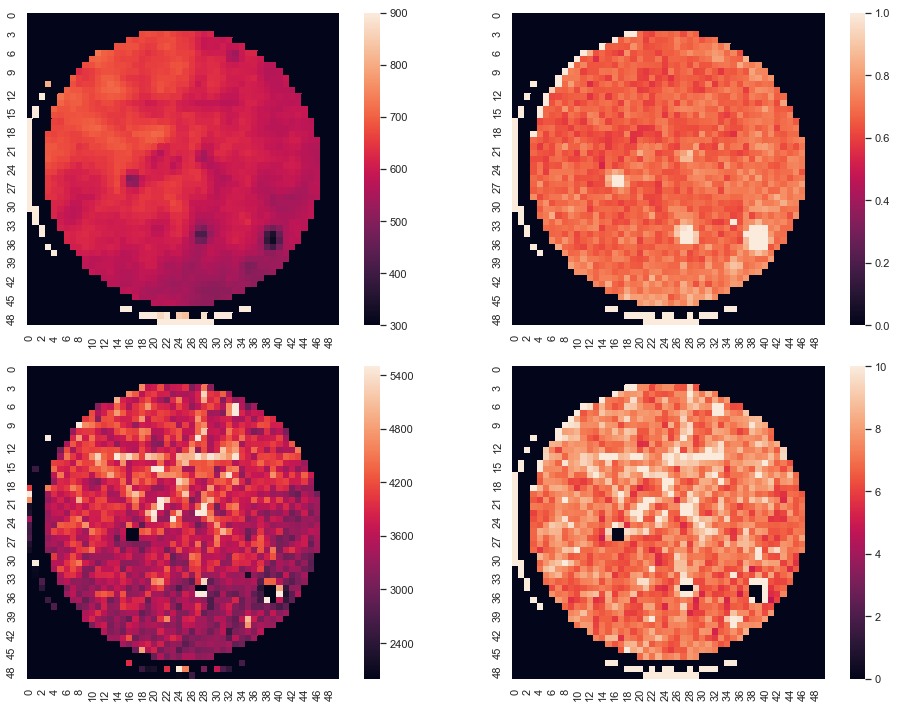

In [78]:
draw_xy_maps(asm2,
            e0lims  = (300, 900),
            ltlims  = (2000, 5500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

## Write Qmaps

In [79]:
asmAv2 = amap_replace_nan_by_mean(asm2, amMean=amv2)

In [80]:
amap_average(asmAv2)

ASectorMap(chi2=1.0002216188572384, e0=629.0618035238673, lt=3689.212044982582, e0u=0.7975816711304031, ltu=8.653728714181359, mapinfo=None)

In [81]:
qsm = add_mapinfo(asmAv2, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=run_number)

In [82]:
qsm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    7431
dtype: int64

In [83]:
print(f'writing qmaps in {qmap_filename}')
write_maps(qsm, filename=qmap_filename)

writing qmaps in /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_qmap_xy_50_50_r_7431.h5


# This completes the part of map-writting

- single-run maps written for energy (emap) and charge (qmap)

# Finally check single-run resolution

## Read back the energy map

In [84]:
emaps = read_maps(filename=emap_filename)

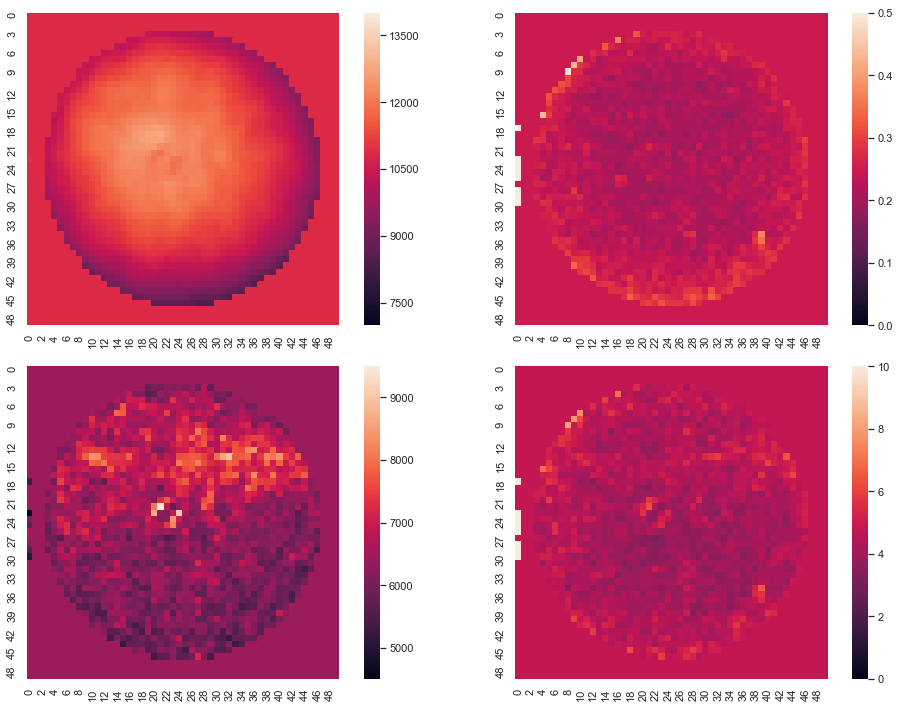

In [85]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (4500, 9500),
            eulims  = (0.0,  0.5),
            lulims  = (0, 10),
            figsize=(14,10))

## Now check the corrections that can be achieved with the single maps

In [86]:
amap_average(emaps)

ASectorMap(chi2=0.9279997842263518, e0=10915.176651177753, lt=6463.687221247295, e0u=0.24143213026445579, ltu=4.58339425731854, mapinfo=None)

In [87]:
norm = amap_max(emaps)

In [88]:
norm

ASectorMap(chi2=2.776283811832176, e0=12812.421625382558, lt=10171.969050653845, e0u=0.8921998636554342, ltu=23.442758799649464, mapinfo=None)

#### E0 correction:

In [89]:
ti = timeit(e0_xy_correction)
E0 = ti(dsts.S2e.values,
        dsts.X.values,
        dsts.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 4.297598838806152 s


## XY (single time) LT correction

In [90]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dsts.X.values, 
       dsts.Y.values,
       dsts.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 3.9820220470428467 s


In [91]:
er = (5000,15000)

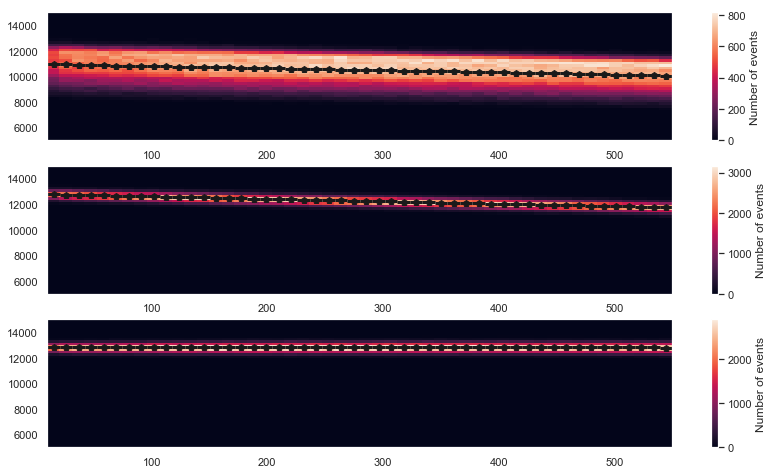

In [92]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dsts.Z, dsts.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dsts.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dsts.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

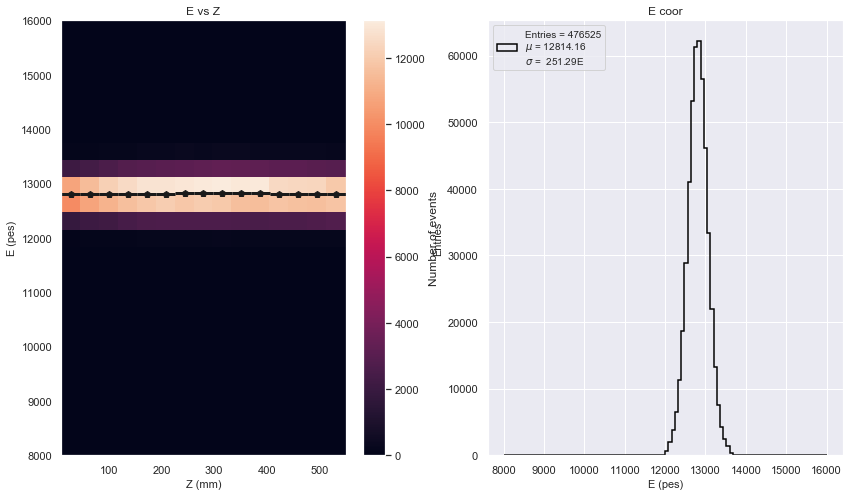

In [93]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dsts.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12813.262408216453 +-0.3671772484710219 
 E sigma   = 249.3456810212157 +-0.28738819294057966 
 chi2    = 3.979446723069818 
 sigma E/E (FWHM)     (%) =4.5730925640304605
 sigma E/E (FWHM) Qbb (%) =0.5906238511870793 


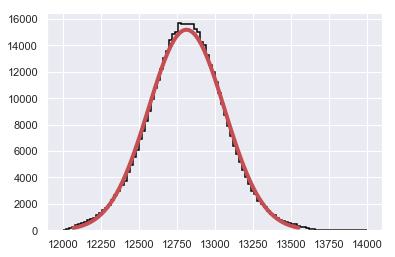

In [94]:
fc = fit_energy(E, nbins=100, range=(12000, 14000))
plot_fit_energy(fc)
print_fit_energy(fc)

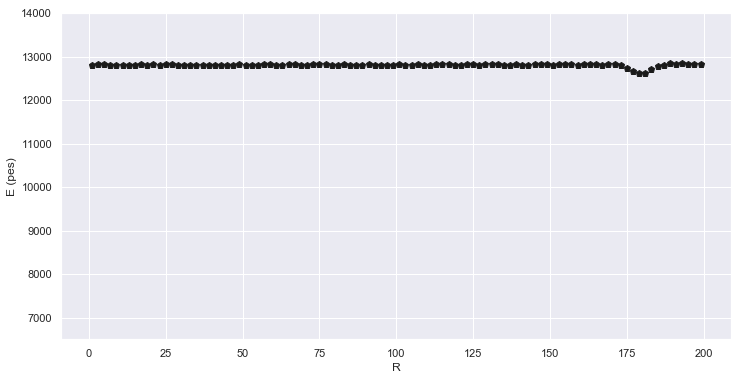

In [95]:
energy_X_profile(dsts.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

## Corrections are OK up to 200! This is due to the band selection!

### Select events in the fiducial region: R < 170

In [96]:
dsts = dsts.assign(E=E)

In [97]:
RFID2 = 170
dst_R     = dsts[dsts.R < RFID2]

### Repeat profles

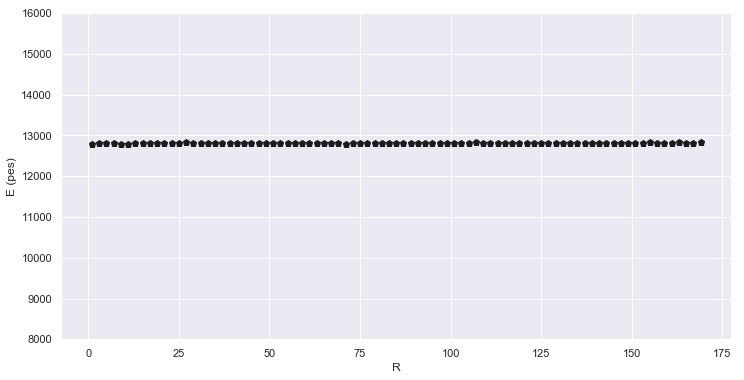

In [98]:
energy_X_profile(dst_R.R, dst_R.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

#### Everything is flat. No need for further corrections. 

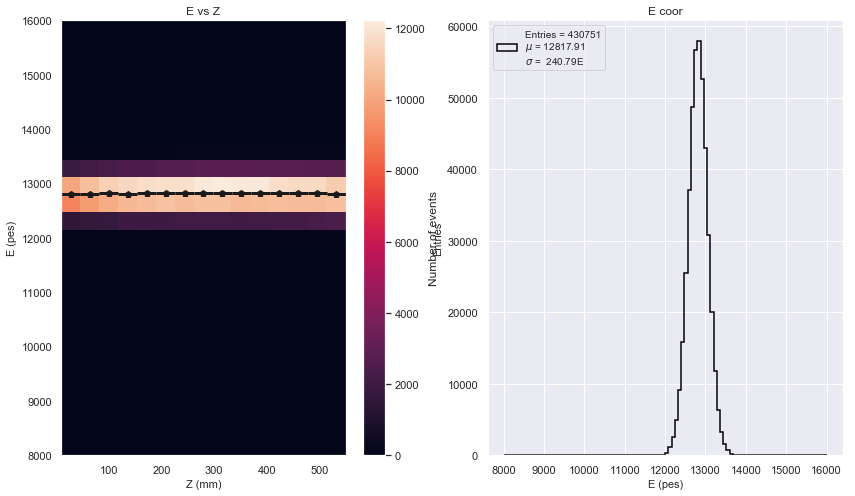

In [99]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12817.654104001049 +-0.37087119500756593 
 E sigma   = 239.62514438494048 +-0.2859224597090477 
 chi2    = 2.4881280903198726 
 sigma E/E (FWHM)     (%) =4.393308516016451
 sigma E/E (FWHM) Qbb (%) =0.5674043896666127 


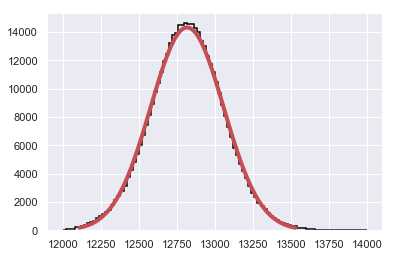

In [100]:
fc = fit_energy(dst_R.E, nbins=100, range=(12000, 14000))
plot_fit_energy(fc)
print_fit_energy(fc)

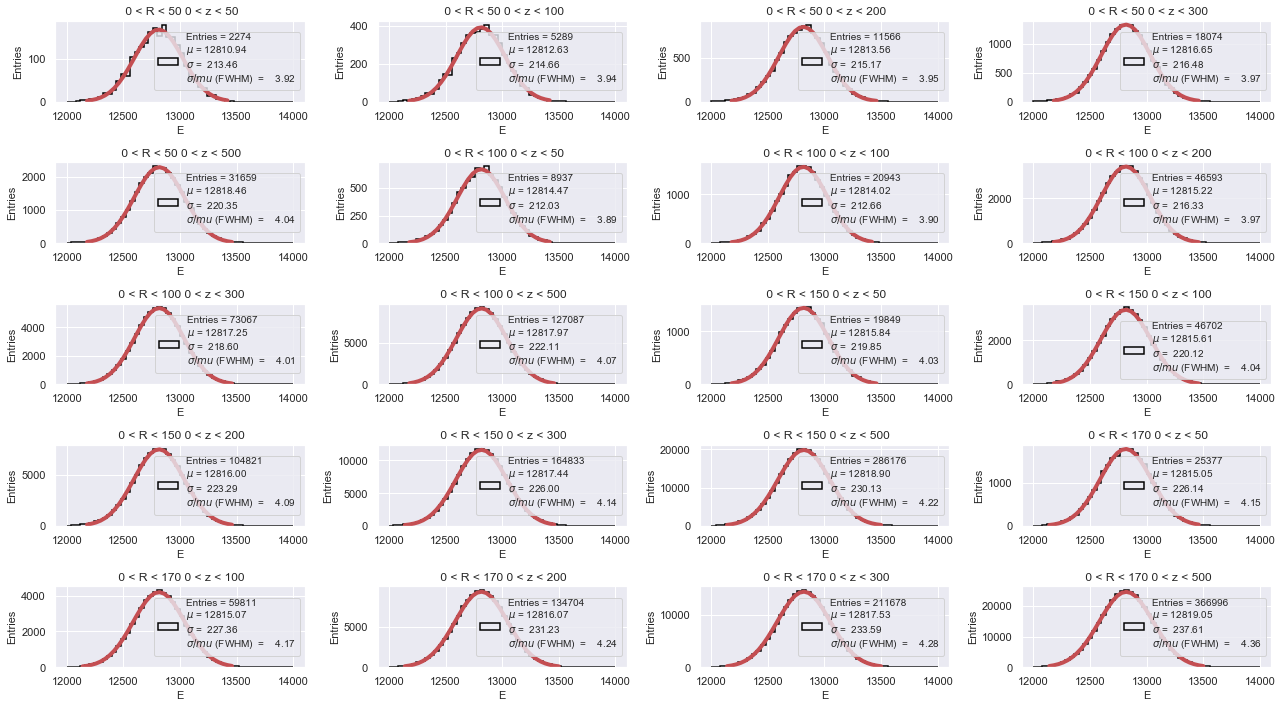

In [101]:
Ri = (50, 100,150,170)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.E,
                    enbins = 50,
                    erange = (12000,14000),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

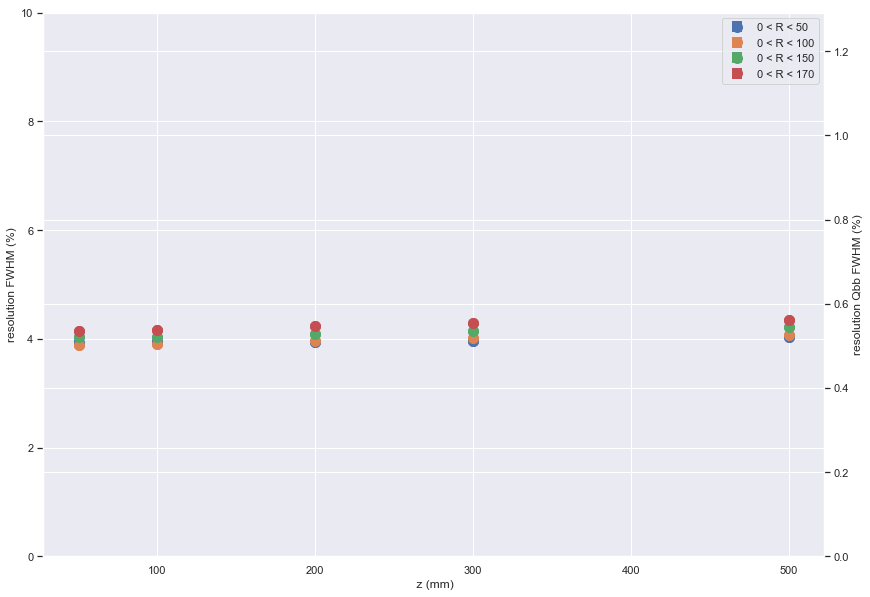

In [102]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

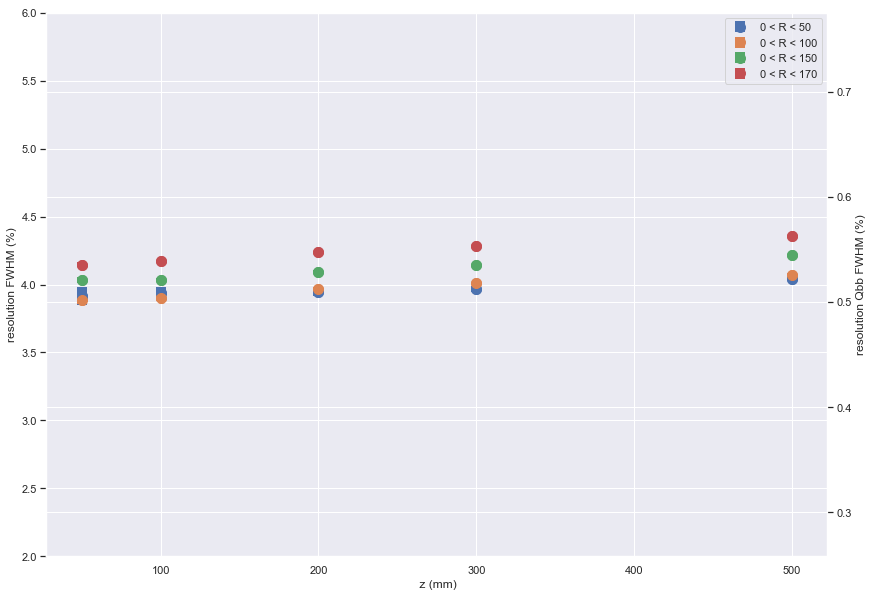

In [103]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(2,6))

# This completes check of resolution. 

# Finally, write the selected dst

In [104]:
dsts.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms', 'E0', 'E'],
      dtype='object')

In [105]:
if (write_filtered_dst):
    print('writing filtered dst ', output_dst_filename)
    kdst_write(dsts, output_dst_filename)

writing filtered dst  /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7431_trigger1_0000_9066.h5
